In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import ast
import glob
from pymbar import timeseries
from GPyOpt.methods import BayesianOptimization

sys.path.append("..")

from tools.utils import cubic_integration

from utils_automated import get_mean_sim_data_lo, train_gpr, g_lambda_i, adapted_distribution, get_partial_uncertanty, get_rmsd, estimate_variance
                                                           

uncorrelated: -0.12270459954815535 all: -0.12256955131791301
own std: 0.114617, other std: 0.113545
uncorrelated: 21.11003513364509 all: 20.978450464593962
own std: 0.369192, other std: 0.371536
uncorrelated: 30.631955943835248 all: 31.23341436086096
own std: 0.863989, other std: 0.832290
uncorrelated: 32.24623713056037 all: 32.973583467883245
own std: 1.168464, other std: 1.211986
uncorrelated: 25.64317180574812 all: 25.89425471844525
own std: 1.121306, other std: 1.145634
uncorrelated: 18.37309917711457 all: 18.623855399504876
own std: 0.965708, other std: 0.973859
uncorrelated: 10.680066673450877 all: 10.904691905041709
own std: 0.519866, other std: 0.529160
uncorrelated: 5.483351327144535 all: 5.317735335897976
own std: 0.415490, other std: 0.445825
uncorrelated: -0.9551751478848642 all: -1.0689037294184405
own std: 0.221100, other std: 0.225029
uncorrelated: -4.790819656091682 all: -4.7206634613221246
own std: 0.136273, other std: 0.129875
uncorrelated: -11.362708912430097 all: -1

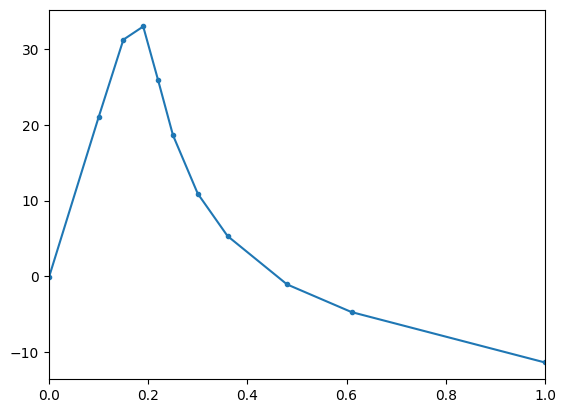


Integration results: 2.99 ± 0.13
Reference: 2.97 ± 0.03


Partial uncertanties
 [0.01932870552928744, 0.023489086691271265, 0.029063966966773717, 0.024291829820871327, 0.02219756583442543, 0.027418662583612197, 0.019965038808091983, 0.028239343446628158, 0.01688194278808986, 0.027721898282042544]

Optimal uncertanty in each lambda step: 0.024

RMSD to optimal value: 17.74%



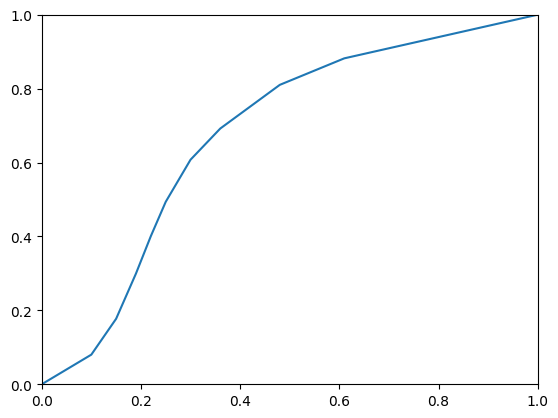

In [15]:
## Read in optimized simulation results

with open("./lammps/ethanol_water/automated/opt_intermediates.log") as f:
    lines = [line for line in f]
    
idx     = [i for i,line in enumerate(lines) if "The optimized intermediates are:" in line][0]
lambdas = ast.literal_eval(lines[idx+1].split("\n")[0])

idx     = [i for i,line in enumerate(lines) if "The job folders indices are:" in line][0]
indices = ast.literal_eval(lines[idx+1].split("\n")[0])
    
test      = '/beegfs/work/st_163811/vle_using_solvation_free_energy/development/lammps/ethanol_water/automated/sim_lj_%d/fep_lj.fep'
paths     = [test%i for i in indices]
mean, var = get_mean_sim_data_lo(paths,len(lambdas))

print(lambdas)
print(np.round(mean,2))
print(np.round(var,3))

plt.plot(lambdas,mean,marker=".")
plt.xlim(0,1)
plt.show()
plt.close()

tmp = cubic_integration(lambdas,mean,var) 
print("\nIntegration results: %.2f ± %.2f"%(tmp[0],tmp[1])) 
print("Reference: 2.97 ± 0.03\n")

dG_i = get_partial_uncertanty(lambdas,var)

print("\nPartial uncertanties\n", dG_i )

rmsd = get_rmsd(dG_i,verbose=True)

gridpoint = g_lambda_i(dG_i)

plt.plot(lambdas, gridpoint/np.max(gridpoint) )
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()
plt.close()

[0.0, 0.1, 0.17, 0.19, 0.21, 0.23, 0.25, 0.27, 0.29, 0.33, 0.36, 0.42, 0.5, 0.61, 0.79, 1.0]
[-0.03 13.03 23.22 25.35 23.64 24.13 21.05 15.93 13.43  7.19  4.4   2.26
 -0.58 -2.58 -5.32 -7.82]
[2.000e-03 1.160e-01 5.930e-01 1.185e+00 2.956e+00 2.430e+00 1.930e+00
 9.030e-01 9.260e-01 2.730e-01 1.770e-01 9.400e-02 6.100e-02 3.300e-02
 7.000e-03 1.000e-03]


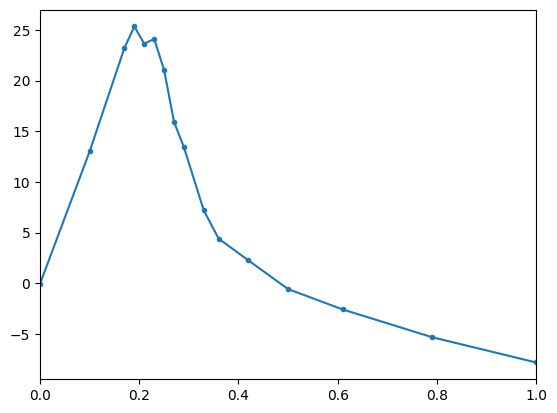


Integration results: 3.03 ± 0.11
Reference: 3.07 ± 0.03


Partial uncertanties
 [0.017113750898146256, 0.02945484204510091, 0.013332025143513861, 0.020349330405475957, 0.023207891796527328, 0.020879945087866166, 0.016829802852558494, 0.013521744723656345, 0.02189463407407413, 0.010057275922335011, 0.015611786893042441, 0.01572773937740764, 0.016845615812222353, 0.01801087285832148, 0.009437228100649685]

Optimal uncertanty in each lambda step: 0.017

RMSD to optimal value: 29.64%



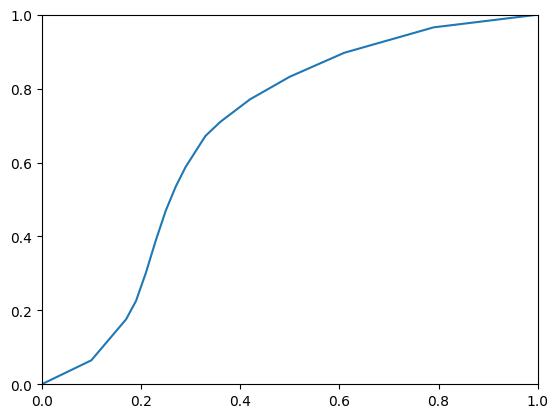

In [2]:
## Read in optimized simulation results

with open("./lammps/methanol_water/automated/opt_intermediates.log") as f:
    lines = [line for line in f]
    
idx     = [i for i,line in enumerate(lines) if "The optimized intermediates are:" in line][0]
lambdas = ast.literal_eval(lines[idx+1].split("\n")[0])

idx     = [i for i,line in enumerate(lines) if "The job folders indices are:" in line][0]
indices = ast.literal_eval(lines[idx+1].split("\n")[0])
    
test      = '/beegfs/work/st_163811/vle_using_solvation_free_energy/development/lammps/methanol_water/automated/sim_lj_%d/fep_lj.fep'
paths     = [test%i for i in indices]
mean, var = get_mean_sim_data_lo(paths,len(lambdas))

print(lambdas)
print(np.round(mean,2))
print(np.round(var,3))

plt.plot(lambdas,mean,marker=".")
plt.xlim(0,1)
plt.show()
plt.close()

tmp = cubic_integration(lambdas,mean,var) 
print("\nIntegration results: %.2f ± %.2f"%(tmp[0],tmp[1])) 
print("Reference: 3.07 ± 0.03\n")

dG_i = get_partial_uncertanty(lambdas,var)

print("\nPartial uncertanties\n", dG_i )

rmsd = get_rmsd(dG_i,verbose=True)

gridpoint = g_lambda_i(dG_i)

plt.plot(lambdas, gridpoint/np.max(gridpoint) )
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()
plt.close()

Optimization restart 1/3, f = -0.0887161753553638
Optimization restart 2/3, f = -0.08871617535457688
Optimization restart 3/3, f = -0.08871617535645804
-2.577127632031698 0.2873561333448666
Optimization restart 1/3, f = -7.113080137524262
Optimization restart 2/3, f = -7.1130801375157695
Optimization restart 3/3, f = -7.113080137519504
-1.0327640193055376 0.044594507097012535


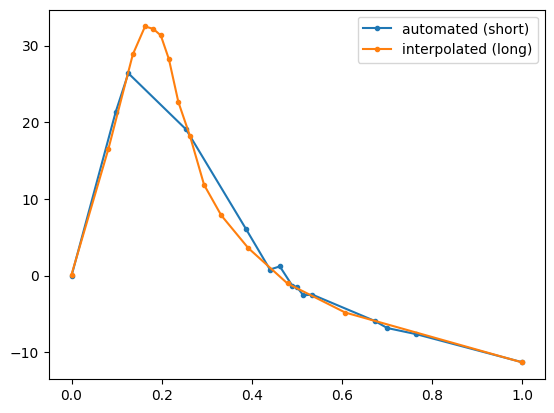

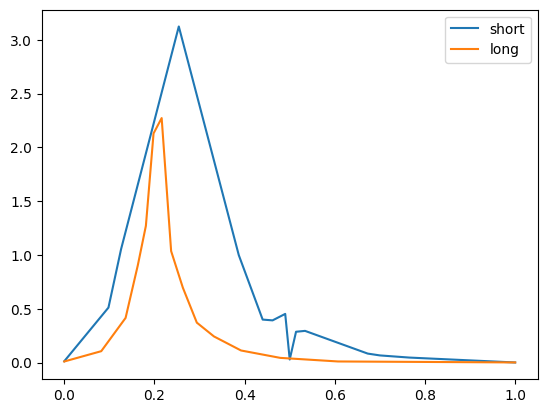

In [58]:
# Short simulation

lambdas   = [ 0.0, 0.098, 0.126, 0.254, 0.387, 0.44, 0.462, 0.49, 0.5, 0.514, 0.534, 0.673, 0.7, 0.765, 1.0]

test      = '/beegfs/work/st_163811/vle_using_solvation_free_energy/development/lammps/ethanol_water/automated/sim_lj_%d/fep_lj.fep'
paths     = [test%i for i in range(len(lambdas))]
mean, var = get_mean_sim_data_lo(paths,len(lambdas))

short_model = train_gpr(lambdas,var)

plt.plot(lambdas,mean,marker=".",label="automated (short)")

idx = lambdas.index( 0.514 )
print(mean[idx],var[idx])

# Long simulation

lambdas   = [0.0, 0.082, 0.136, 0.163, 0.181, 0.198, 0.216, 0.237, 0.263, 0.294, 0.332, 0.392, 0.479, 0.607, 1.0]

test      = '/beegfs/work/st_163811/vle_using_solvation_free_energy/development/lammps/ethanol_water/opt_adapted/sim_lj_%d/fep_lj.fep'
paths     = [test%i for i in range(len(lambdas))]
mean, var = get_mean_sim_data_lo(paths,len(lambdas))

long_model = train_gpr(lambdas,var)

plt.plot(lambdas,mean,marker=".",label="interpolated (long)")

idx = lambdas.index( 0.479 )
print(mean[idx],var[idx])

plt.legend()
plt.show()
plt.close()

plt.plot(short_model.X,short_model.Y,label="short")
plt.plot(long_model.X,long_model.Y,label="long")
plt.legend()
plt.show()
plt.close()

In [8]:
# Compare restart from near lambda to sim no restart 

# Ref with 5 ns
paths     = ["./lammps/ethanol_water/automated/test_validation/fep_lj.fep"]
m_5, v_5 = get_mean_sim_data_lo(paths,1)

print("\nMean from long simulation (5 ns) without restart: %.3f ± %.3f"%(m_5[0],v_5[0]))

# 600 ps simulation
paths     = ["./lammps/ethanol_water/automated/test_restart/fep_lj_600ps.fep","./lammps/ethanol_water/automated/test_norestart/fep_lj_600ps.fep"]
m_06, v_06 = get_mean_sim_data_lo(paths,2)

print("\n600 ps")
print("Mean with restart: %.3f ± %.3f -> mrd: %.2f%%"%(m_06[0],v_06[0], abs( (m_5-m_06[0])/m_5 ) *100 ) )
print("Mean with no restart: %.3f ± %.3f -> mrd: %.2f%%\n"%(m_06[1],v_06[1], abs( (m_5-m_06[1])/m_5 ) *100 ))

# 1000 ps simulation
paths     = ["./lammps/ethanol_water/automated/test_restart/fep_lj_1000ps.fep","./lammps/ethanol_water/automated/test_norestart/fep_lj_1000ps.fep"]
m_1, v_1 = get_mean_sim_data_lo(paths,2)

print("\n1000 ps")
print("Mean with restart: %.3f ± %.3f -> mrd: %.2f%%"%(m_1[0],v_1[0], abs( (m_5-m_1[0])/m_5 ) *100 ) )
print("Mean with no restart: %.3f ± %.3f -> mrd: %.2f%%\n"%(m_1[1],v_1[1], abs( (m_5-m_1[1])/m_5 ) *100 ))




Mean from long simulation (5 ns) without restart: 31.943 ± 0.375

600 ps
Mean with restart: 33.705 ± 2.295 -> mrd: 5.52%
Mean with no restart: 31.154 ± 2.117 -> mrd: 2.47%


1000 ps
Mean with restart: 32.182 ± 2.120 -> mrd: 0.75%
Mean with no restart: 32.506 ± 1.556 -> mrd: 1.76%

